# Descripcion del hardware

Procesador: Intel(R) Core(TM) i5 8300H CPU @ 2.3GHz 2.3GHz

Ram: 20 Gb

Optane: 20 Gb

Vram:4Gb

Tarjeta de video: Nvidia  GeForce GTX 1050 @ compute capability: 6.1

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os 

print(tf.version)
tf.test.is_gpu_available(cuda_only=True, min_cuda_compute_capability=None)

<module 'tensorflow_core._api.v2.version' from 'C:\\Users\\jeiss\\.conda\\envs\\rstudio\\lib\\site-packages\\tensorflow_core\\_api\\v2\\version\\__init__.py'>


True

In [2]:
# Ruta raiz
PATH = 'C:/Users/jeiss/Documents/Repositorio para JupyterLab - Jupyter Noteboock/Mineria de Datos/Proyecto'
# Ruta de datos de entrada 
INPATH = PATH + '/inputFlowers'
# Ruta de datos de salida
OUPATH = PATH + '/outputFlowers'
# Ruta para los checkpoints
CKPATH = PATH + '/checkpoints'

imgurls = os.listdir(INPATH)

In [3]:
n = 1000
train_n = round(n*0.8)

randurls = np.copy(imgurls)
np.random.seed(23)
np.random.shuffle(randurls)

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(np.array(randurls).shape)
print(np.array(tr_urls).shape)
print(len(imgurls),len(tr_urls),len(ts_urls))


(8189,)
(800,)
8189 800 200


In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
#rescalado de imagenes
def resize(inimg,tgimg,height,weidth):
    inimg = tf.image.resize(inimg,[height,weidth])
    tgimg = tf.image.resize(tgimg,[height,weidth])    
    return inimg , tgimg 

def normalize(inimg,tgimg):
    inimg = (inimg/127.5) - 1
    tgimg = (tgimg/127.5) - 1 
    return inimg,tgimg

@tf.function()
def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)
    
    stacked_image = tf.stack([inimg,tgimg] , axis=0)
    cropped_image = tf.image.random_crop(stacked_image,size = [2,IMG_WIDTH, IMG_HEIGHT , 3]) 
    inimg , tgimg = cropped_image[0], cropped_image[1]
    
    if tf.random.uniform(()) > 0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)
        print()
    return inimg,tgimg
        
def load_image(filename,augment = True):
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)[...,:3]#limitando solo a 4 componentes de 3 colores RGB
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)),tf.float32)[...,:3]#
    
    inimg , tgimg  = resize(inimg , tgimg , IMG_HEIGHT,IMG_WIDTH)
    
    if augment:
        inimg , tgimg = random_jitter(inimg , tgimg)
        
    inimg , tgimg = normalize(inimg , tgimg)
    return inimg , tgimg

def load_train_image(filename):
    return load_image(filename,augment = True)

def load_test_image(filename):
    return load_image(filename,augment = False)


image_07739.jpg
0.0 1.0


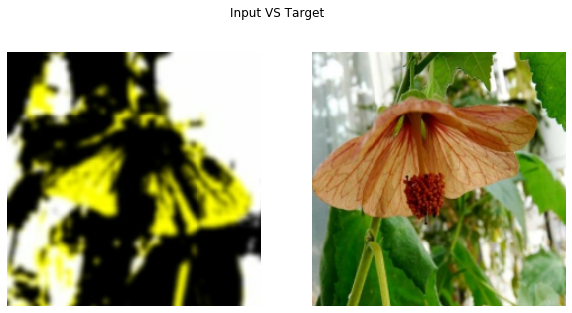

In [6]:
print(randurls[0])
train_img_input = (load_train_image(randurls[0])[0] + 1) /2
train_img_targe = (load_train_image(randurls[0])[1] + 1) /2

print(np.min(train_img_input.numpy()),np.max(train_img_input.numpy()))
with tf.device('/device:GPU:0'):
    fig , ax  = plt.subplots(1,2,figsize=(10,5)) 
    
    ax[0].imshow(train_img_input)
    ax[1].imshow(train_img_targe)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.suptitle('Input VS Target')
    plt.show()
    

In [7]:
from tensorflow.python.client import device_lib
tf.test.is_built_with_cuda()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14857503583051576835,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3147261542
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14678116927158910338
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

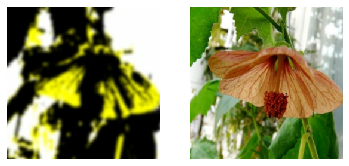

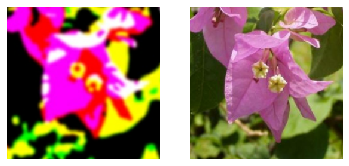

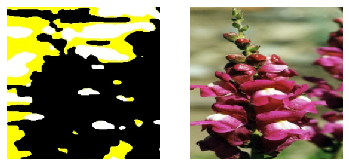

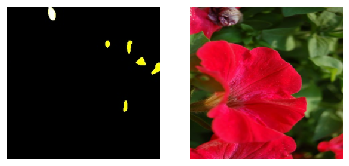

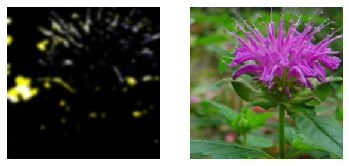

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image , num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image , num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for inimg , tgimg  in train_dataset.take(5):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(((inimg[0,...] )  +1 ) /2 ) 
    ax[1].imshow(((tgimg[0,...] )  +1 ) /2 ) 
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()
    

In [9]:
from tensorflow.keras import *
from tensorflow.keras.layers import * 

def downsample(filters , apply_batchnorm = True ):
    result = Sequential()
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    result.add(Conv2D(filters,
                     kernel_size = 4,
                     strides = 2,
                     padding = "same",
                     kernel_initializer = initializer,
                     use_bias = not apply_batchnorm))
    
    if apply_batchnorm:
        result.add(BatchNormalization())
    
    result.add(LeakyReLU())
    return result
    
downsample(64)

In [10]:
def upsample(filters , apply_dropout = False ):
    result = Sequential()
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    result.add(Conv2DTranspose(filters,
                               kernel_size = 4,
                               strides = 2,
                               padding = "same",
                               kernel_initializer = initializer,
                               use_bias = False))
    
   
    result.add(BatchNormalization())
    result.add(Dropout(0.5))
    result.add(ReLU())
    return result
    
upsample(64)

In [11]:
def Generator():
    inputs = tf.keras.layers.Input(shape = [None,None,3])
    
    down_stack= [
        downsample(64,apply_batchnorm = False),
        downsample(128),
        downsample(256),
        downsample(512),
        downsample(512),
        downsample(512),
        downsample(512),
        downsample(512)       
    ] 
    
    up_stack = [
        upsample(512,apply_dropout=True),
        upsample(512,apply_dropout=True),
        upsample(512,apply_dropout=True),
        upsample(512),
        upsample(256),
        upsample(128),
        upsample(64)
    ]
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    last = Conv2DTranspose(filters = 3,
                        kernel_size = 2,
                        strides = 2,
                        padding = 'same',
                        kernel_initializer = initializer,
                        activation = 'tanh')
    
    x = inputs
    s = []
    
    concat = Concatenate()
    for down in down_stack:
        x = down(x)
        s.append(x)
        
    s = reversed(s[:-1])
    
    for up , sk  in zip(up_stack,s) :
        x = up(x)
        x = concat([x,sk])
        
    last = last(x)
    
    return Model(inputs = inputs , outputs = last)

0.0 1.0


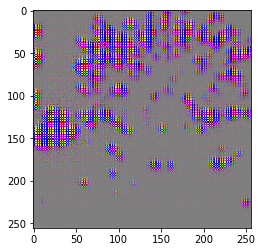

In [12]:
generator = Generator()
gen_output = generator(((inimg+1)*255) , training = False )
gen_output = (gen_output+1)/2
print(np.min(gen_output[0,...]),np.max(gen_output[0,...]))
plt.imshow(gen_output[0,...])

In [13]:
def Discriminator():
    
    ini = Input(shape = [None,None,3] , name = 'input_img')
    gen = Input(shape = [None,None,3] , name = 'gener_img')
    
    concat = Concatenate()
    con = concat([ini,gen])
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    down1 = downsample(64 , apply_batchnorm = False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)

    last = tf.keras.layers.Conv2D(filters = 1 ,
                                  kernel_size = 4,
                                  strides = 1,
                                  padding = 'same',
                                  kernel_initializer = initializer)(down4)
    
    return tf.keras.Model(inputs = [ini,gen] , outputs = last)
    

In [14]:
Discriminator()

TensorShape([1, 16, 16, 1])

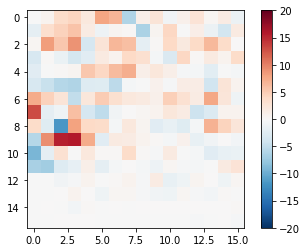

In [15]:
discriminator = Discriminator()
disc_out = discriminator([((inimg+1)*255) , gen_output] ,training = False)
plt.imshow(disc_out[0,...,-1],vmin = -20 , vmax = 20 , cmap = 'RdBu_r')
plt.colorbar()
disc_out.shape

In [16]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss
    

In [18]:
LAMBDA = 100 
def generator_loss(disc_generated_output, gen_output , target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [19]:
generator_optimazer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)
discriminator_optimazer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)

In [20]:
checkpoint_prefix = os.path.join(CKPATH,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimazer = generator_optimazer,
                                 discriminator_optimazer = discriminator_optimazer,
                                 generator = generator,
                                 discriminator = discriminator)


In [21]:
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [22]:
def generate_images(model , test_input , tar , save_filename = False, display_imags = True):
    
    prediction = model(test_input,training = True)
    
    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH + '/GeneratedFlowers/' + save_filename + '.jpg', prediction[0,...])#output/
        
    plt.figure(figsize = (10,10))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image','Ground Truth', 'Predicted Image']
    
    if display_imags:
        for i in range(3):
            plt.subplot(1,3,i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
    plt.show()
     

In [23]:
@tf.function()
def train_step(input_image,target):
    
    with tf.GradientTape() as gen_tape , tf.GradientTape() as discr_tape:
        output_image = generator(input_image, training = True)
        
        output_gen_discr = discriminator([output_image, input_image], training = True )
        
        output_trg_discr = discriminator([target, input_image], training = True )
        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
        gen_loss = generator_loss(output_gen_discr , output_image , target)

        generator_grads = gen_tape.gradient(gen_loss , generator.trainable_variables)
        discriminator_grads = discr_tape.gradient(discr_loss , discriminator.trainable_variables)
        
        generator_optimazer.apply_gradients(zip(generator_grads,generator.trainable_variables))
        discriminator_optimazer.apply_gradients(zip(discriminator_grads , discriminator.trainable_variables))

In [24]:
from IPython.display import clear_output

def train(dataset,epochs):
    for epoch in range(epochs):
        imgi = 0 
        for input_image , target in dataset:
            print('epoch: ' + str(epoch) + '   - train: '  + str(imgi) + '/' + str(len(tr_urls)))
            imgi = imgi + 1 
            train_step(input_image,target)
            clear_output(wait=True)
        
        imgi = 0
        for inp , tar in test_dataset.take(10):
            generate_images(generator,inp,tar, str(imgi) + '_' + str(epoch),display_imags=True)
            imgi += 1
        if (epoch + 1 ) % 25 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        

In [ ]:
train(train_dataset,300)

epoch: 226   - train: 147/800


In [ ]:
checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
with tf.device('/device:GPU:0'):
    for inimg , tgimg in train_dataset.take(216):
        fig, ax = plt.subplots(1,2,figsize = (10,10))
        ax[0].imshow(((inimg[0,...] )  +1 ) /2 )
        ax[1].imshow(((tgimg[0,...] )  +1 ) /2 )
        ax[0].axes('off')
        ax[1].axes('off')
        plt.show()